Deep Learning for Disaster Tweet Classification - Machine learning Final 
Charisma Ricarte
Trieu Do
Jonathan Garcia	

Dataset source: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets?select=tweets.csv 

Run on TAMU HPC LAUNCH Cluster

In [32]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: NVIDIA A30


In [33]:
import pandas as pd
dataset = pd.read_csv("tweets.csv", # the location to the data file
                       sep=",", nrows = 10000
                       )
dataset

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...,...
9995,9995,terrorism,NaN,3yrs after IPOB formed Biafra security Service...,0
9996,9996,terrorism,www,France agrees to send more troops to West Afri...,1
9997,9997,terrorism,USA,"While the press feasts off a tiny ""he-said, sh...",0
9998,9998,terrorism,North Pole,● NEWS ● #meduza #russia ☞ Man who made Russia...,0


In [34]:
# clean text of symbols and non-letters, etc. 
# should help standardize words, for example: "FIRE!!!", "fire.", and "fire🔥" now all map to "fire"
# helps prevent un needed token usage 

import re        # for regular expressions (text cleaning)

def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+", "", t)  # remove URLs
    t = re.sub(r"@\w+", "", t)     # remove mentions
    t = re.sub(r"#", "", t)        # remove hashtag symbols (keep the word)
    t = re.sub(r"[^a-z\s]", "", t) # remove non-letters
    return t.strip()
dataset["clean_text"] = dataset["text"].apply(clean_text)

In [35]:
# import libraries to clean and prepare our dataset for our models - Bag of words binary feature matrix 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
vectorizer = CountVectorizer(binary=True, stop_words="english") # 1 or 0 indicating if word appears in tweet and removes english words like "the", "and" and "is"
X = vectorizer.fit_transform(dataset["clean_text"]) # converts each tweet into a vector of 0s and 1s
df_tf = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out()) # takes every word and places it as a column name 
df_tf # predictors (independent variables)

,aa,aaaaaaaaacccccckkkkkkkk,aab,aadharcard,aalaathun,aampe,aampes,aap,aaron,aayega,...,zonal,zone,zoo,zoom,zoomedin,zorro,zuckerberg,zulaykhas,zuma,zw
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Decided to try a different vectorizer - TF-IDF - weighted feature matrix 
This vectorizer will assign weights to words. Words with more importance get a higher weight while words with less importance get a smaller weight. 
It performs much better than the binary vectorizer above. There are more meaningful words found, and this will help in training models. 

In [36]:
vectorizer = TfidfVectorizer(
    norm="l2",
    stop_words="english",
    ngram_range=(1,2),      # include unigrams + bigrams
    max_features=20000,     # cap vocab size - helps remove characters or words that have no meaning or very rare occurence
    lowercase=True
)
X = vectorizer.fit_transform(dataset["clean_text"])  # use your cleaned text column

# take a look at the first 100 rows of new dataframe 
pd.DataFrame(X[:100].toarray(), columns=vectorizer.get_feature_names_out())

,aab battle,aadharcard,aadharcard ad,aalaathun,aalaathun balaa,aampe,aampe life,aampes,aampes queen,aap,...,zombies run,zombies time,zombievirus,zonal,zonal cooling,zone,zoo,zoom,zuma,zuma did
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Partition the data set
# create pipeline to prevent data leakage 
# Setup baseline - logistic regression 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_text = dataset["clean_text"]  
y = dataset["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.20, random_state=123, stratify=y
)

# Logistic Regression model- baseline

pipe = make_pipeline(
    TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=20000),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.942     0.910     0.926      1647
           1      0.638     0.739     0.685       353

    accuracy                          0.880      2000
   macro avg      0.790     0.825     0.805      2000
weighted avg      0.889     0.880     0.883      2000



0 = Non-disaster tweets 
1 = Disaster Tweets 
Precision = out of all tweets predicted as “disaster,” how many actually were?
Recall = out of all real disaster tweets, how many did the model correctly identify?
F1-score = harmonic mean of precision & recall (balances both)
Support = number of true samples in that class

1st run 
The LR model is performing well overall for a 70/20 split 
It does really well at finding non-disaster tweets with an F1-score of 92% and ok at finding disaster tweets at 67% 
The support reveals that there were over 2400 samples of 

              precision    recall  f1-score   support

           0      0.936     0.913     0.924      2470
           1      0.635     0.708     0.669       530

    accuracy                          0.876      3000
   macro avg      0.785     0.810     0.797      3000
weighted avg      0.882     0.876     0.879      3000


2nd run - will use this one for baseline
LR model baseline improved with an 80/20 split. 
The F1 score improved for disaster tweet detection by almost 1 point. Accuracy, macro avg, and weighted average also improved slightly. 

 precision    recall  f1-score   support

           0      0.940     0.909     0.924      1647
           1      0.631     0.728     0.676       353

    accuracy                          0.877      2000
   macro avg      0.786     0.818     0.800      2000
weighted avg      0.885     0.877     0.880      2000

# Setup environment for Transformer Model 


In [38]:
# check to see if any transformer is installed
import os, textwrap, sys

print("Repo root contents:", os.listdir("."))
if "src" in os.listdir("."):
    print("src contents:", os.listdir("src"))
else:
    print("No src folder found")

# Quick search for anything with 'transformer' in the code
!grep -R "transformer" -n src || echo "No 'transformer' string found in src"

Repo root contents: ['tweets.csv', 'src', 'Disaster Tweets ML Final.ipynb', 'Untitled.ipynb', 'main.py', 'requirements.txt', 'README.md', '.ipynb_checkpoints', 'training_loss_curve.png', 'data', '__pycache__', 'eda_target_distribution.png', 'metrics_summary.png']
src contents: ['utils.py', 'train_eval.py', 'model.py', '__pycache__', 'preprocess.py']

Binary file src/__pycache__/preprocess.cpython-310.pyc matches
Binary file src/__pycache__/preprocess.cpython-312.pyc matches
Binary file src/__pycache__/model.cpython-310.pyc matches
Binary file src/__pycache__/model.cpython-312.pyc matches



# install transformer library

In [39]:
import sys
print("Python executable for this notebook:", sys.executable)

# Install transformers into THIS exact Python env
!{sys.executable} -m pip install transformers

Python executable for this notebook: /scratch/user/u.jg335414/.conda/envs/pytorch_env/bin/python


In [40]:
!{sys.executable} -m pip install datasets accelerate

In [41]:
import sys
!{sys.executable} -m pip install package_name

In [42]:
import sys, os

# Make sure we're in the repo root 
print("CWD:", os.getcwd())
print("Contents:", os.listdir("."))

# So that `src.*` imports work
sys.path.append(os.path.abspath("."))

from src.preprocess import load_and_preprocess
from src.model import create_model
from src.train_eval import train_model
from src.utils import plot_metrics

CWD: /ccstar/scratch/user/u.jg335414/ml_final/ML_DisasterResponse-main
Contents: ['tweets.csv', 'src', 'Disaster Tweets ML Final.ipynb', 'Untitled.ipynb', 'main.py', 'requirements.txt', 'README.md', '.ipynb_checkpoints', 'training_loss_curve.png', 'data', '__pycache__', 'eda_target_distribution.png', 'metrics_summary.png']


In [43]:
# Run transformer model 
# 1. Load and preprocess the data from 1st transformer run 
train_enc, val_enc, train_labels, val_labels, num_labels = load_and_preprocess("data/tweets.csv")

# 2. Create the BERT model
model = create_model(num_labels)

# explicitly move to GPU, if train_model doesn't already do it inside
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

# 3. Train the model
train_losses, val_accs = train_model(
    model,
    train_enc,
    val_enc,
    train_labels,
    val_labels,
)

# 4. Plot metrics (this likely saves a PNG and/or shows a plot)
plot_metrics(train_losses, val_accs)

print("Training complete. Metrics and plots saved.")

Reading file from: /ccstar/scratch/user/u.jg335414/ml_final/ML_DisasterResponse-main/data/tweets.csv
Dataset shape: (11370, 5)
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Epoch 1/2: 100%|██████████| 569/569 [00:46<00:00, 12.32it/s]


Epoch 1 - Loss: 0.2798, Val Acc: 0.8997


Epoch 2/2: 100%|██████████| 569/569 [00:46<00:00, 12.23it/s]


Epoch 2 - Loss: 0.1496, Val Acc: 0.9006
Training complete. Metrics and plots saved.


In [44]:
# view metrics
train_losses, val_accs

([0.27983387835611884, 0.14962983658367043],
 [0.899736147757256, 0.9006156552330695])

Model is performing very well with accuracy at about 90%. Results will vary because there isnt a seed setup for model. 
Still the model is able to classify each tweet that is a disaster or non-disaster correctly about 90% of the time. 

Training loss is below .3 on the first epoch then below .15 on the 2nd. Its a significant improvement from one epoch to the next. This is the average error between the prediction and the the true label during training. It shows that the model was able to learn patterns in the text during the first epoch and was therefore able to get less errors during the 2nd epoch. 


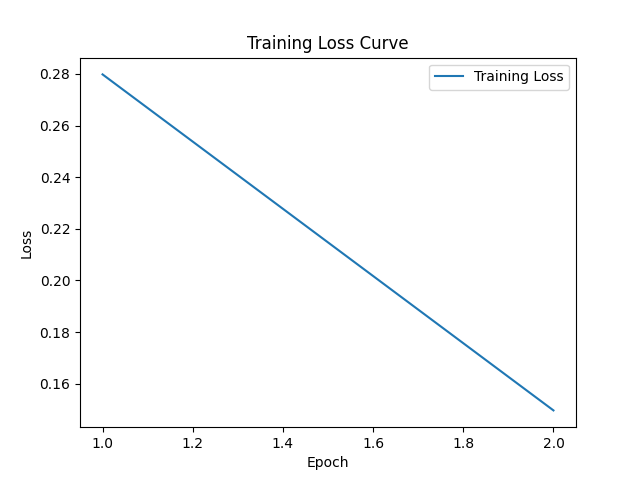

In [45]:
# This image is showing the models imrpovment from epoch 1 to epoch 2. The training loss decreases. This means the model is getting more predictions correct and less wrong.
from IPython.display import Image
Image("training_loss_curve.png")

In [49]:
# Get best Accuracy, Precision, Recall and F1 Score
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(len(val_labels)):
        input_ids = val_enc["input_ids"][i].unsqueeze(0).to(device)
        attention_mask = val_enc["attention_mask"][i].unsqueeze(0).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1).item()

        all_preds.append(pred)
        all_labels.append(val_labels[i])

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

results_BaseEpoch = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

for metric, value in results_BaseEpoch.items():
    print(f"{metric.capitalize():<10}: {value:.4f}")

Accuracy  : 0.9006
Precision : 0.6943
Recall    : 0.8322
F1        : 0.7570


In [50]:
# for reproducibiility set seed - this ensure the results are reproducible every time the model is run  
# set train/validation split to deterministic - also helps with reproducibility 
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# make CUDA/dataloader slightly more deterministic 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [51]:
# Run model again with 4 epochs and observe 
 
# 1. Load and preprocess the data from 1st transformer run 
train_enc, val_enc, train_labels, val_labels, num_labels = load_and_preprocess("data/tweets.csv")

# 2. Create the BERT model
model = create_model(num_labels)

# explicitly move to GPU, if train_model doesn't already do it inside
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

train_losses, val_accs = train_model(
    model,
    train_enc,
    val_enc,
    train_labels,
    val_labels,
    epochs=4,
    batch_size=16,
)


Reading file from: /ccstar/scratch/user/u.jg335414/ml_final/ML_DisasterResponse-main/data/tweets.csv
Dataset shape: (11370, 5)
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Epoch 1/4: 100%|██████████| 569/569 [00:46<00:00, 12.30it/s]


Epoch 1 - Loss: 0.2766, Val Acc: 0.9103


Epoch 2/4: 100%|██████████| 569/569 [00:46<00:00, 12.21it/s]


Epoch 2 - Loss: 0.1503, Val Acc: 0.9125


Epoch 3/4: 100%|██████████| 569/569 [00:46<00:00, 12.17it/s]


Epoch 3 - Loss: 0.0624, Val Acc: 0.9077


Epoch 4/4: 100%|██████████| 569/569 [00:46<00:00, 12.15it/s]


Epoch 4 - Loss: 0.0373, Val Acc: 0.9103


Performs about the same as first transformer run on epoch 1 and 2. Much better results in the Training loss decreasing below 10% on epoch 3. Model is finding patterns very well. 

Accuracy has stayed about the same, still over 90% 

In [52]:
# now change learning rate from lr2e-5 to lr=1e-5. A lower learning rate should help BERT with higher epochs. 

# 1. Load and preprocess the data from 1st transformer run 
train_enc, val_enc, train_labels, val_labels, num_labels = load_and_preprocess("data/tweets.csv")

# 2. Create the BERT model
model = create_model(num_labels)

# explicitly move to GPU, if train_model doesn't already do it inside
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

train_losses, val_accs = train_model(
    model,
    train_enc,
    val_enc,
    train_labels,
    val_labels,
    epochs=4,
    batch_size=16,
    lr=1e-5
    
)

# 4. Plot metrics (this likely saves a PNG and/or shows a plot)
plot_metrics(train_losses, val_accs)

Reading file from: /ccstar/scratch/user/u.jg335414/ml_final/ML_DisasterResponse-main/data/tweets.csv
Dataset shape: (11370, 5)
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Epoch 1/4: 100%|██████████| 569/569 [00:46<00:00, 12.15it/s]


Epoch 1 - Loss: 0.2804, Val Acc: 0.9112


Epoch 2/4: 100%|██████████| 569/569 [00:47<00:00, 12.09it/s]


Epoch 2 - Loss: 0.1714, Val Acc: 0.8971


Epoch 3/4: 100%|██████████| 569/569 [00:47<00:00, 12.09it/s]


Epoch 3 - Loss: 0.0988, Val Acc: 0.9134


Epoch 4/4: 100%|██████████| 569/569 [00:47<00:00, 12.09it/s]


Epoch 4 - Loss: 0.0503, Val Acc: 0.9200


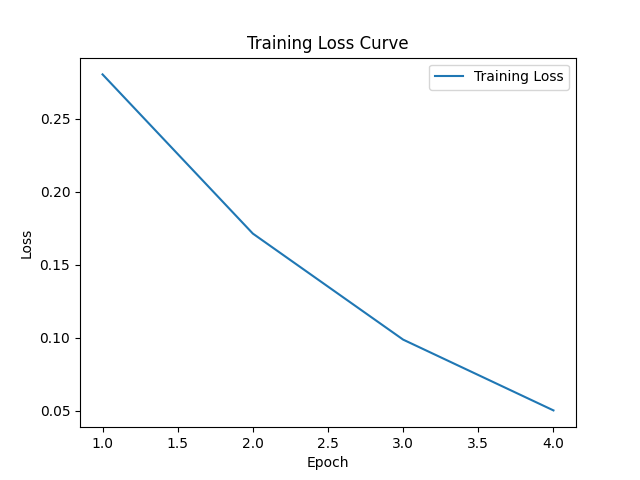

In [53]:
# This image is showing the models imrpovment from epoch 1 to epoch 2. The training loss decreases. This means the model is getting more predictions correct and less wrong.
from IPython.display import Image
Image("training_loss_curve.png")

Changing the learning rate helped the model significantly on epochs 3 and 4. The model does better on training loss and accuracy. 

In [54]:
# Get Accuracy, Precision, Recall and F1 Score
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(len(val_labels)):
        input_ids = val_enc["input_ids"][i].unsqueeze(0).to(device)
        attention_mask = val_enc["attention_mask"][i].unsqueeze(0).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1).item()

        all_preds.append(pred)
        all_labels.append(val_labels[i])

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

results_4Epoch = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

for metric, value in results_4Epoch.items():
    print(f"{metric.capitalize():<10}: {value:.4f}")

Accuracy  : 0.9200
Precision : 0.7862
Recall    : 0.7825
F1        : 0.7844


In [55]:
# now increase epoch to 6 
# 1. Load and preprocess the data from 1st transformer run 
train_enc, val_enc, train_labels, val_labels, num_labels = load_and_preprocess("data/tweets.csv")

# 2. Create the BERT model
model = create_model(num_labels)

# explicitly move to GPU, if train_model doesn't already do it inside
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

train_losses, val_accs = train_model(
    model,
    train_enc,
    val_enc,
    train_labels,
    val_labels,
    epochs=6,
    batch_size=16,
    lr=1e-5
    
)

# 4. Plot metrics (this likely saves a PNG and/or shows a plot)
plot_metrics(train_losses, val_accs)

Reading file from: /ccstar/scratch/user/u.jg335414/ml_final/ML_DisasterResponse-main/data/tweets.csv
Dataset shape: (11370, 5)
   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Epoch 1/6: 100%|██████████| 569/569 [00:46<00:00, 12.18it/s]


Epoch 1 - Loss: 0.2776, Val Acc: 0.9077


Epoch 2/6: 100%|██████████| 569/569 [00:46<00:00, 12.16it/s]


Epoch 2 - Loss: 0.1716, Val Acc: 0.9164


Epoch 3/6: 100%|██████████| 569/569 [00:47<00:00, 12.10it/s]


Epoch 3 - Loss: 0.1001, Val Acc: 0.9147


Epoch 4/6: 100%|██████████| 569/569 [00:47<00:00, 12.09it/s]


Epoch 4 - Loss: 0.0552, Val Acc: 0.9178


Epoch 5/6: 100%|██████████| 569/569 [00:47<00:00, 12.09it/s]


Epoch 5 - Loss: 0.0372, Val Acc: 0.9156


Epoch 6/6: 100%|██████████| 569/569 [00:47<00:00, 12.09it/s]


Epoch 6 - Loss: 0.0278, Val Acc: 0.9217


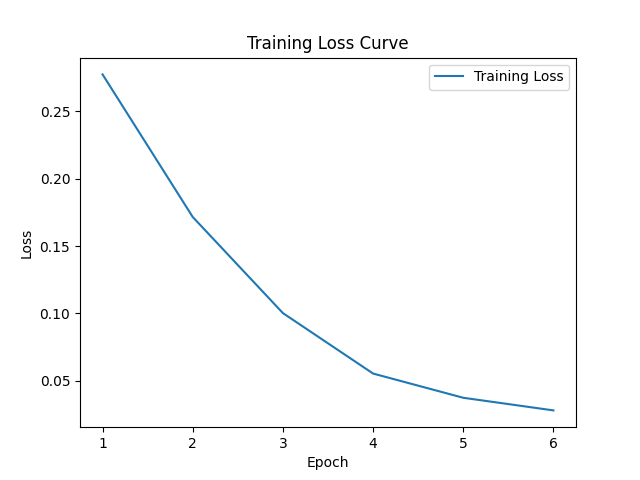

In [56]:
# This image is showing the models imrpovment from epoch 1 to epoch 2. The training loss decreases. This means the model is getting more predictions correct and less wrong.
from IPython.display import Image
Image("training_loss_curve.png")

Slight imporvement - training loss is almost to 0 - anymore training will likely result in overfitting. It means the model is starting to memorize training data. The Accuracy is also going slightly up and down and will likely not improve with more epochs. 

In [57]:
# Get Accuracy, Precision, Recall and F1 Score
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for i in range(len(val_labels)):
        input_ids = val_enc["input_ids"][i].unsqueeze(0).to(device)
        attention_mask = val_enc["attention_mask"][i].unsqueeze(0).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(outputs.logits, dim=1).item()

        all_preds.append(pred)
        all_labels.append(val_labels[i])

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

results_6Epoch = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

for metric, value in results_6Epoch.items():
    print(f"{metric.capitalize():<10}: {value:.4f}")

Accuracy  : 0.9217
Precision : 0.7778
Recall    : 0.8109
F1        : 0.7940


The Transformer performed better than the Logisitic Regression baseline model on every run. The Transformer was able to differentiate between disaster and non-disaster tweets at least 1 point better that the Logistic Regression model. The best on the logisitc regression model was an accuracy score of 88% which was just under the lowest accuracy score for the Transfomer, which was the transformer base run was 89%. 